In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
wireplane = "Z"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
    #    for k in range(nticks):
    #        waveforms.append(data[string+str(k)].astype(np.int16))
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    # filtered_peak = extract_peak_info(cln_filtered_data)[1]  # before
    filtered_peak = extract_peak_info(filtered_data)[1]  # new
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

# Checking data

In [3]:
#Load Training Data
#path = "../../dunesnb/1dcnn/train/train/nu_cc/"
#path2 = "../../dunesnb/1dcnn/train/train/nu_es/"

# NEW DATA SET WITH
path = "../../Workspace/new_data/train_v1/nu_cc/"
path2 = "../../Workspace/new_data/train_v1/nu_cc/"

test1_sig = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
test1_clean = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]

test2_sig = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
test2_clean = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]


In [4]:
print(len(test1_sig), len(test1_clean))
print(len(test2_sig), len(test2_clean))

55 55
55 55


In [5]:
combined_test1_sig = np.concatenate([np.load(fname) for fname in test1_sig])
combined_test1_clean = np.concatenate([np.load(fname) for fname in test1_clean])

combined_test2_sig = np.concatenate([np.load(fname) for fname in test2_sig])
combined_test2_clean = np.concatenate([np.load(fname) for fname in test2_clean])

In [6]:
wave_nu_cc_sig = get_std_waveforms(combined_test1_sig)
wave_nu_cc_clean = get_std_waveforms(combined_test1_clean)

wave_nu_es_sig = get_std_waveforms(combined_test2_sig)
wave_nu_es_clean = get_std_waveforms(combined_test2_clean)

In [7]:
print(wave_nu_cc_sig.shape, wave_nu_cc_clean.shape)
print(wave_nu_es_sig.shape, wave_nu_es_clean.shape)

(114709, 200) (114709, 200)
(114709, 200) (114709, 200)


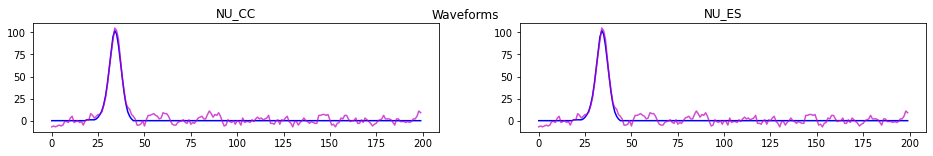

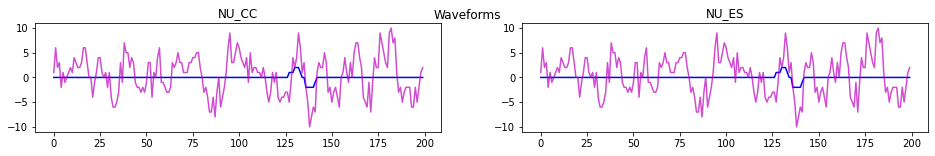

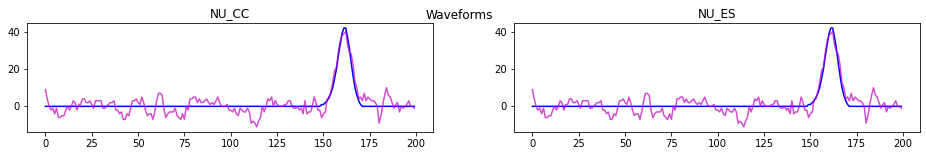

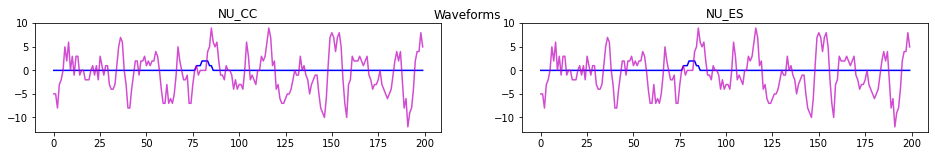

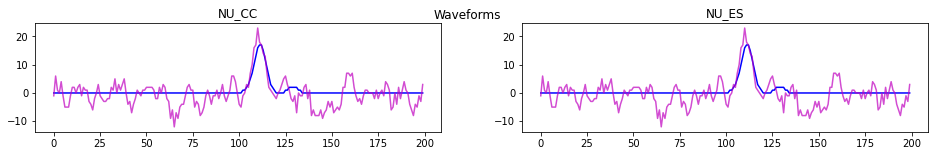

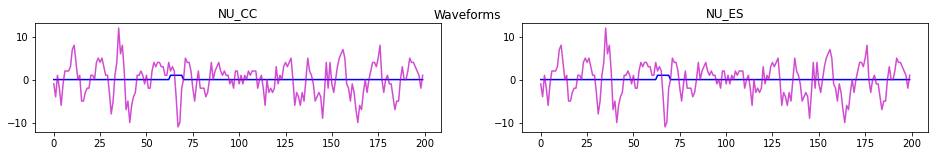

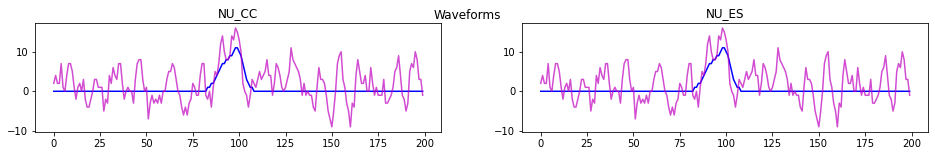

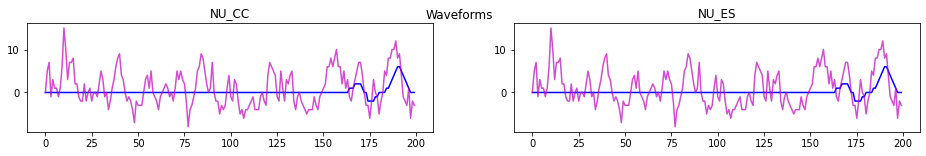

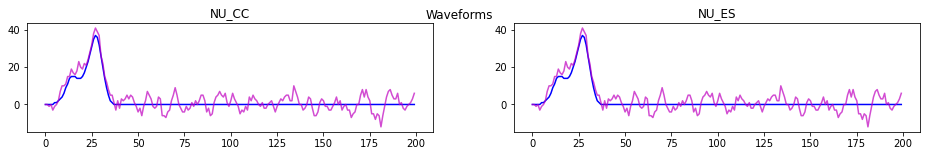

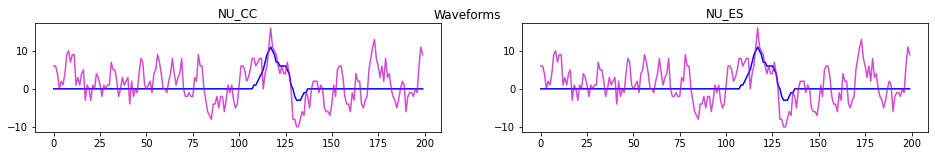

In [8]:
num = 0
for idx in range(num,num+10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
    fig.suptitle('Waveforms')
    ax1.plot(wave_nu_cc_clean[idx],color='blue', label='clean')
    ax1.plot(wave_nu_cc_sig[idx],color='m',alpha=0.7, label='data')
    ax1.set_title("NU_CC")

    ax2.plot(wave_nu_es_clean[idx],color='blue', label='clean')
    ax2.plot(wave_nu_es_sig[idx],color='m',alpha=0.7, label='data')
    ax2.set_title("NU_ES")
    plt.show()

In [9]:
def filter_signal_ADC(data, clean_data, adc_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if max(clean_data[i]) < 10:
            data_wf.append(data[i])
            clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

In [10]:
tes1, tes2 = filter_signal_ADC(wave_nu_cc_sig, wave_nu_cc_clean, 10)
tes3, tes4 = filter_signal_ADC(wave_nu_es_sig, wave_nu_es_clean, 10)

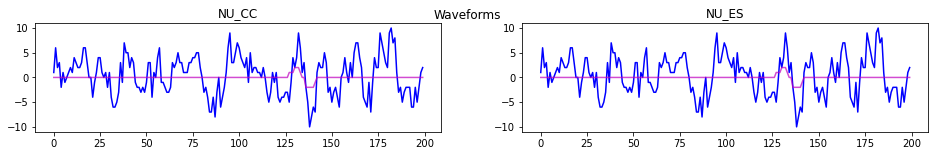

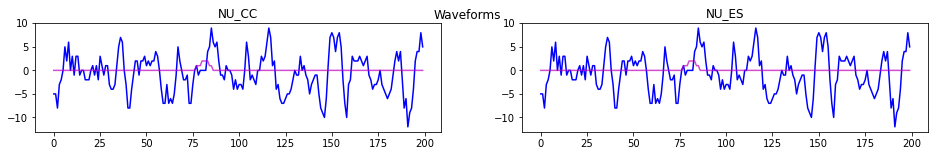

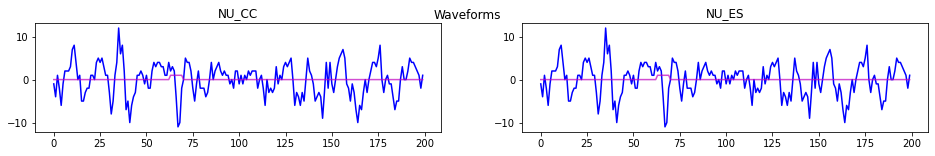

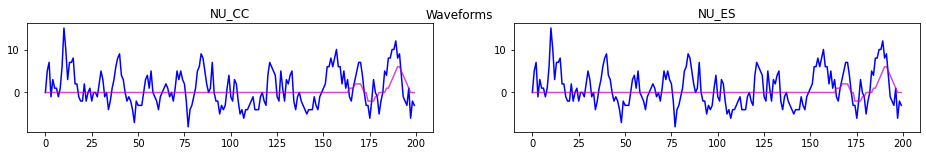

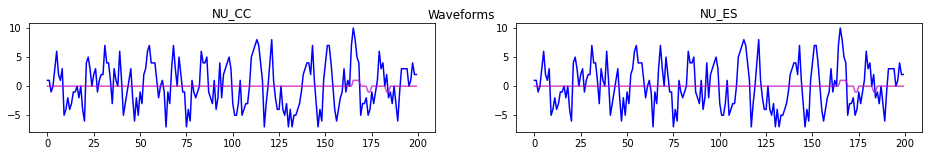

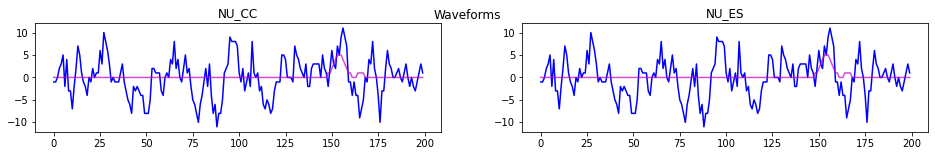

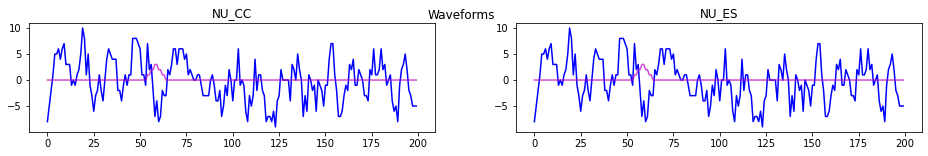

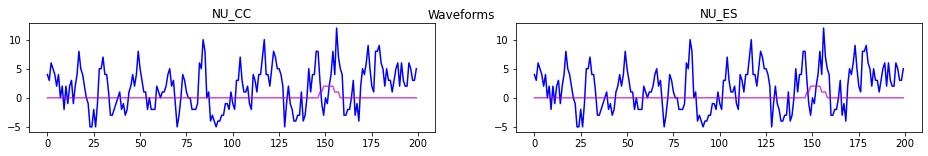

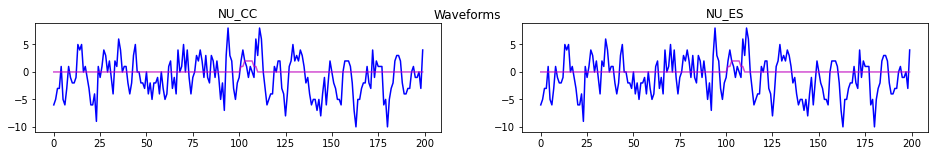

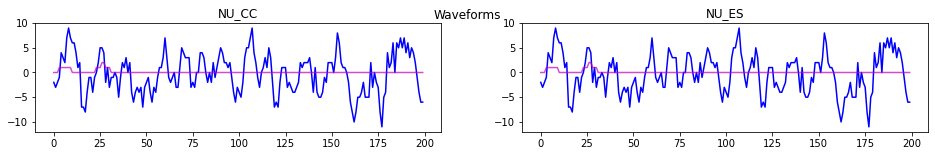

In [11]:
num = 0
for idx in range(num,num+10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
    fig.suptitle('Waveforms')
    ax1.plot(tes1[idx],color='blue', label='clean')
    ax1.plot(tes2[idx],color='m',alpha=0.7, label='data')
    ax1.set_title("NU_CC")

    ax2.plot(tes3[idx],color='blue', label='clean')
    ax2.plot(tes4[idx],color='m',alpha=0.7, label='data')
    ax2.set_title("NU_ES")
    plt.show()

# -------------------------------------------------------

In [12]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

# NEW DATA SET WITH
path = "../../Workspace/new_data/train_v1/nu_cc/"
path2 = "../../Workspace/new_data/train_v1/nu_cc/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
#combined_data = combined_data[:100000]
combined_clean_data = np.concatenate([np.load(fname) for fname in clean_filenames])
#combined_clean_data = combined_clean_data[:100000]

noise_path = "../../Workspace/new_data/train_v1/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)))]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])

In [13]:
combined_noise.shape

(300000,)

# Train/Noise Data Preprocessing

In [14]:
from sklearn.utils import shuffle
print("Unfiltered:" + str(combined_data.shape[0]))
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print("> ADC_MIN:" + str(combined_data.shape[0]))

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.1, shuffle=True
)
print("Train Split:" + str(combined_data.shape[0]))
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)  # for training + valid
clean_signal_waveforms = get_std_waveforms(combined_clean_data)  # target for training + valid
print("Train Split Filtered ADC_MIN < x < ADC_MAX:" + str(combined_data.shape[0]))

#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)
noiseless_waveform = noise_waveforms*0  # "clean" noise

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
test_clean_waveforms = get_std_waveforms(x_test_clean)  # this will be target for test
print("Test Set:" + str(test_signal_waveforms.shape[0]) + ' ' + str(test_clean_waveforms.shape[0]))

Unfiltered:229418
> ADC_MIN:133494
Train Split:120144
Train Split Filtered ADC_MIN < x < ADC_MAX:119501
Test Set:13350 13350


In [15]:
print(noise_waveforms.shape, noiseless_waveform.shape)
print(signal_waveforms.shape, clean_signal_waveforms.shape)


(300000, 200) (300000, 200)
(119501, 200) (119501, 200)


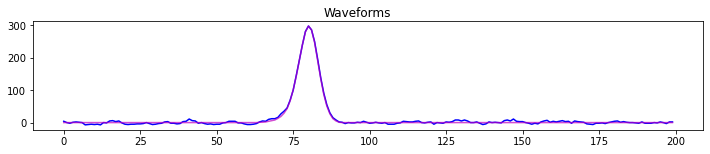

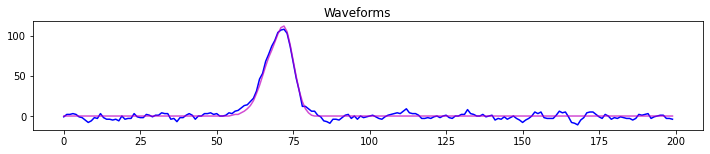

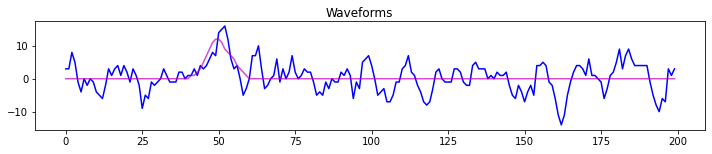

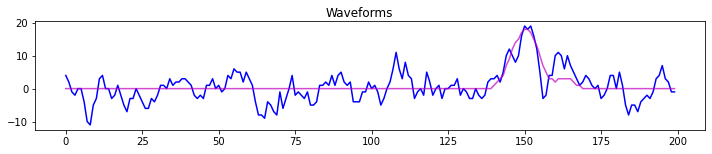

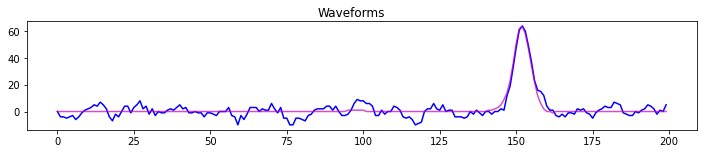

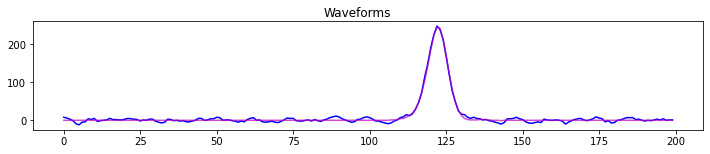

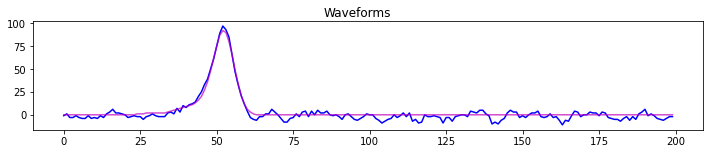

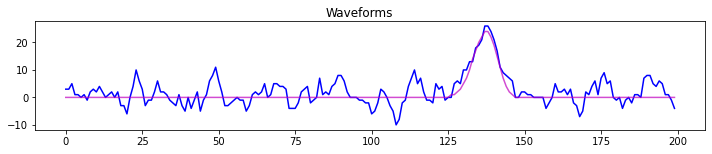

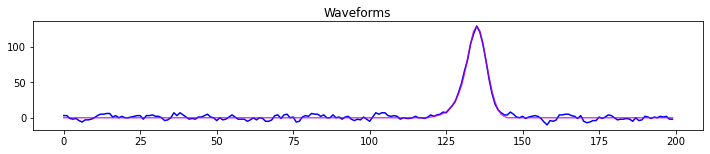

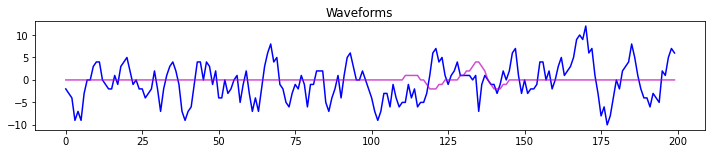

In [16]:
num = 0
for idx in range(num,num+10):
    fig, (ax1) = plt.subplots(figsize=(12, 2))
    fig.suptitle('Waveforms')
    ax1.plot(signal_waveforms[idx],color='blue', label='clean')
    ax1.plot(clean_signal_waveforms[idx],color='m',alpha=0.7, label='data')

    #ax2.plot(tes3[idx],color='blue', label='clean')
    #ax2.plot(tes4[idx],color='m',alpha=0.7, label='data')
    #ax2.set_title("NU_ES")
    plt.show()

# RUN THE FOLLOWING TO MAKE ADC CUT, ELSE SKIP TO: SKIP HERE

In [17]:
def filter_signal_ADC(data, clean_data, adc_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if max(clean_data[i]) < adc_max:
            data_wf.append(data[i])
            clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

In [18]:
print(signal_waveforms.shape, clean_signal_waveforms.shape)
print(test_signal_waveforms.shape, test_clean_waveforms.shape)

(119501, 200) (119501, 200)
(13350, 200) (13350, 200)


In [19]:
signal_waveforms, clean_signal_waveforms = filter_signal_ADC(signal_waveforms, clean_signal_waveforms, 10)
test_signal_waveforms, test_clean_waveforms = filter_signal_ADC(test_signal_waveforms, test_clean_waveforms, 10)

In [20]:
print(signal_waveforms.shape, clean_signal_waveforms.shape)
print(test_signal_waveforms.shape, test_clean_waveforms.shape)

(23062, 200) (23062, 200)
(2674, 200) (2674, 200)


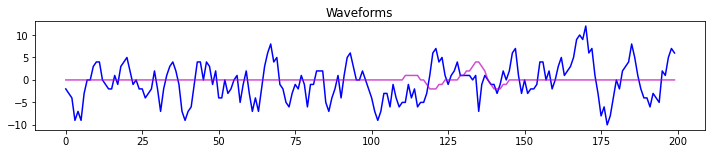

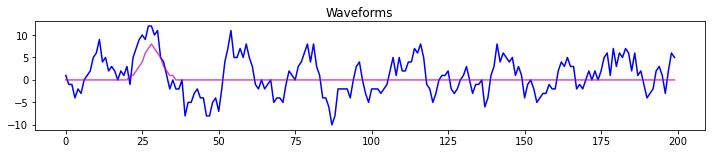

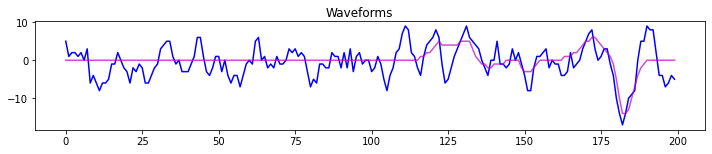

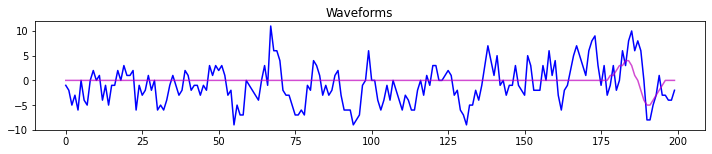

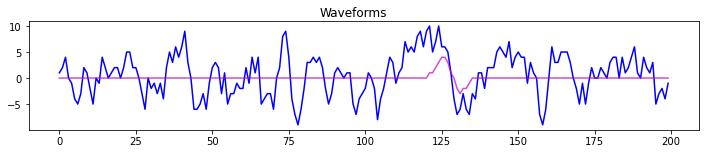

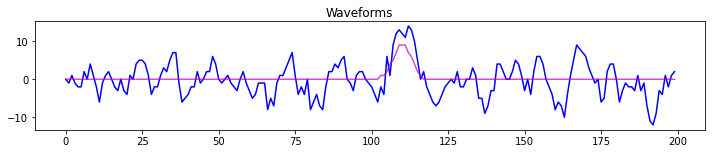

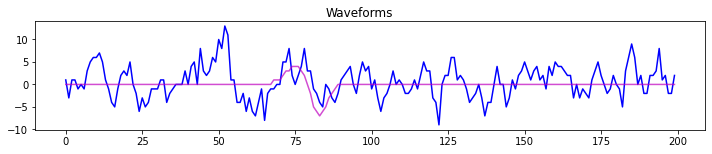

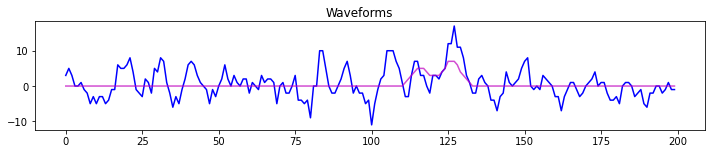

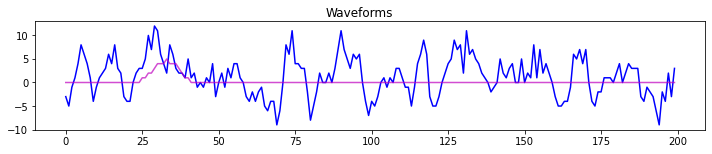

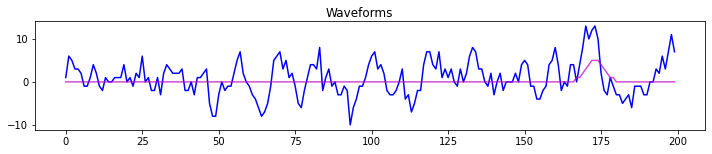

In [21]:
num = 0
for idx in range(num,num+10):
    fig, (ax1) = plt.subplots(figsize=(12, 2))
    fig.suptitle('Waveforms')
    ax1.plot(signal_waveforms[idx],color='blue', label='clean')
    ax1.plot(clean_signal_waveforms[idx],color='m',alpha=0.7, label='data')

    #ax2.plot(tes3[idx],color='blue', label='clean')
    #ax2.plot(tes4[idx],color='m',alpha=0.7, label='data')
    #ax2.set_title("NU_ES")
    plt.show()

# SKIP HERE

In [22]:
# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, noiseless_waveform, test_size=0.5, shuffle=True)
#x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms[:40000], noiseless_waveform[:40000], test_size=0.5, shuffle=True)
#Shuffle signal waveforms to be safe
signal_waveforms, target_signal = shuffle(signal_waveforms, clean_signal_waveforms)
#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms, test_clean_waveforms)

In [23]:
print(signal_waveforms.shape, target_signal.shape)

(23062, 200) (23062, 200)


In [24]:
print(x_noise_train.shape, x_noise_test.shape, y_noise_test.shape, y_noise_train.shape)
x_noise_train = x_noise_train[:30000]
y_noise_train = y_noise_train[:30000]
print(x_noise_train.shape, x_noise_test.shape, y_noise_test.shape, y_noise_train.shape)

(150000, 200) (150000, 200) (150000, 200) (150000, 200)
(30000, 200) (150000, 200) (150000, 200) (30000, 200)


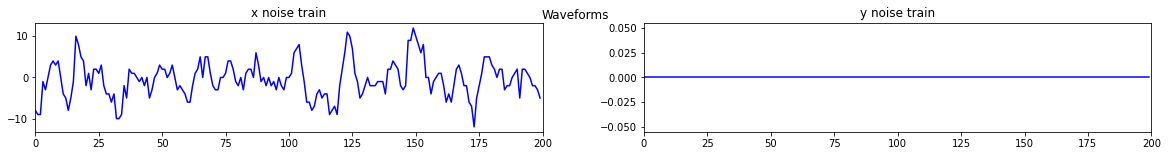

In [25]:
start_for_plot = 0
idx = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
fig.suptitle('Waveforms')
ax1.plot(x_noise_train[idx],color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("x noise train")

ax2.plot(y_noise_train[idx],color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("y noise train")

plt.show()

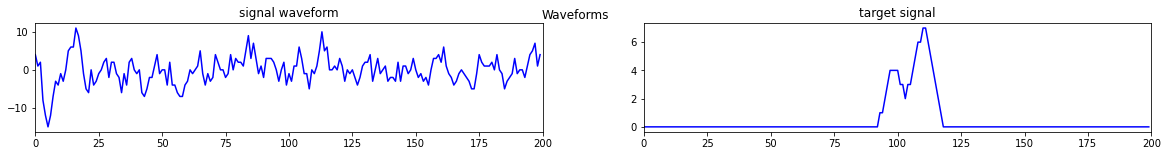

In [26]:
start_for_plot = 0
idx = 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
fig.suptitle('Waveforms')
ax1.plot(signal_waveforms[idx],color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("signal waveform")

ax2.plot(target_signal[idx],color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("target signal")

plt.show()

In [27]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(30000, 200) (23062, 200) (2674, 200)


In [28]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((target_signal[:int(x_noise_train.shape[0])], y_noise_train))

#x_train = signal_waveforms
#y_train = target_signal

# for training using sig+noise as target, but zero when wave contains NO signal
y_train_flat_noise_target = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test[:int(x_noise_test.shape[0])], y_noise_test))

y_test_flat_noise_target = np.concatenate((x_test[:int(x_noise_test.shape[0])], y_noise_test))

In [29]:
#print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(152674, 200) (152674, 200)


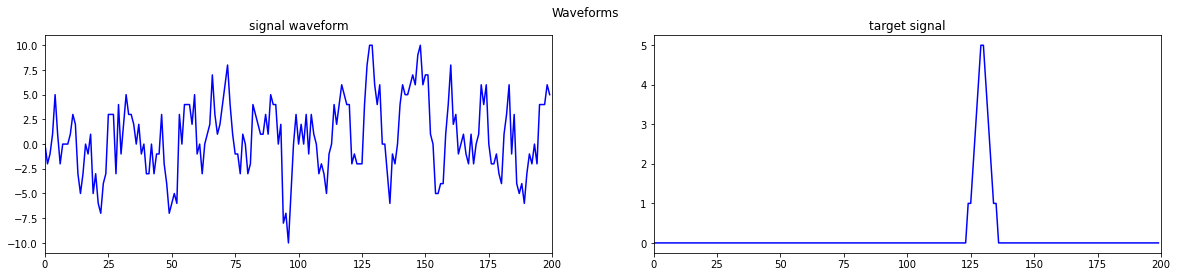

In [30]:
start_for_plot = 0
idx = 7
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('Waveforms')
ax1.plot(x_train[idx],color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("signal waveform")

ax2.plot(y_train[idx],color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("target signal")

plt.show()

In [31]:
# extra train shuffle for good measure 
#x_train, y_train, y_train_flat_noise_target = shuffle(x_train,y_train, y_train_flat_noise_target)
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
#x_test, y_test, y_test_flat_noise_target = shuffle(x_test,y_test, y_test_flat_noise_target)
x_test, y_test = shuffle(x_test,y_test)

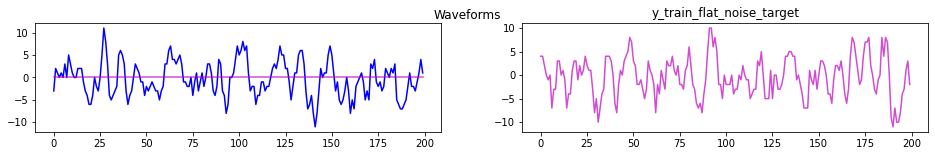

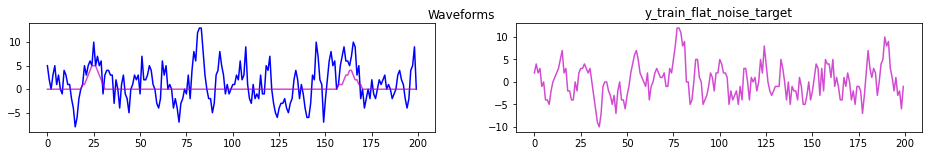

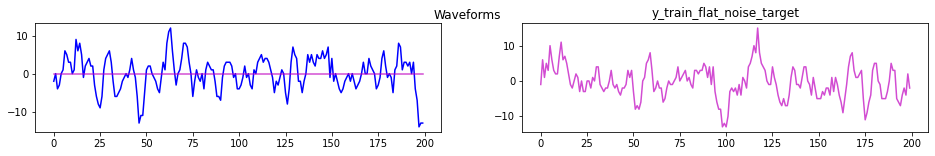

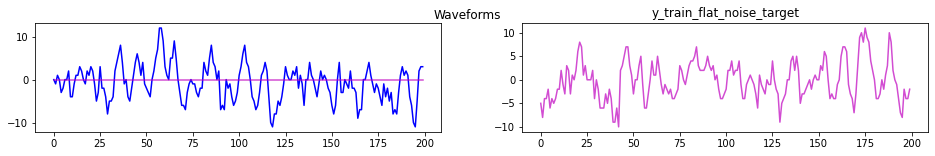

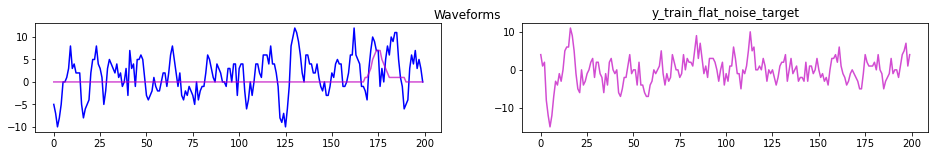

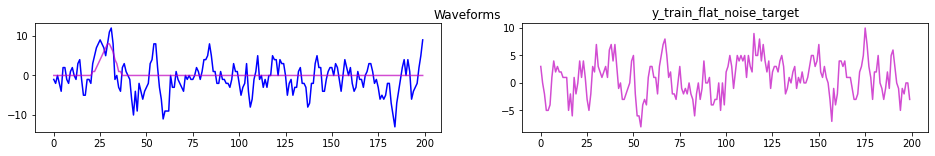

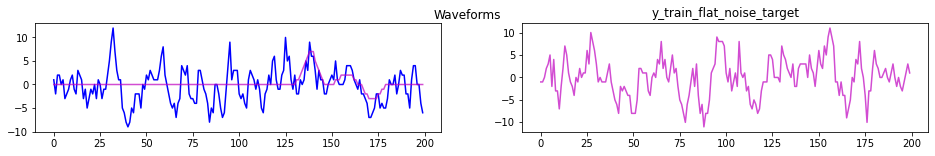

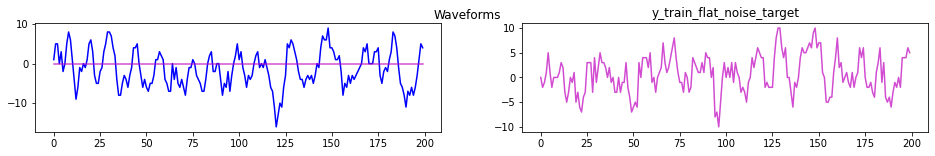

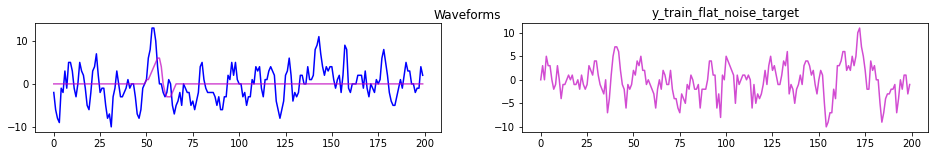

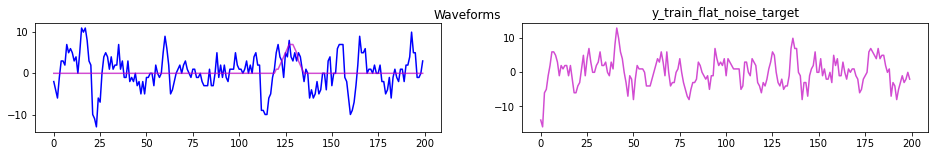

In [32]:
num = 0
for idx in range(num,num+10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
    fig.suptitle('Waveforms')
    ax1.plot(x_train[idx],color='blue', label='clean')
    ax1.plot(y_train[idx],color='m',alpha=0.7, label='data')

    ax2.plot(y_train_flat_noise_target[idx],color='m',alpha=0.7, label='data')
    ax2.set_title("y_train_flat_noise_target")
    plt.show()

In [33]:
np.save('processed_data/x_train_' + wireplane, x_train)
np.save('processed_data/y_train_' + wireplane, y_train)
#np.save('processed_data/y_train_flat_noise_target_' + wireplane, y_train_flat_noise_target)

np.save('processed_data/x_test_' + wireplane, x_test)
np.save('processed_data/y_test_' + wireplane, y_test)
#np.save('processed_data/y_test_flat_noise_target_' + wireplane, y_test_flat_noise_target)